### MLP's in Pytorch

In [16]:
import time
import numpy as np
from glob import glob
from os import listdir, walk
from os.path import isfile, join
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim

In [17]:
%matplotlib inline

In [18]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True
is_cuda

True

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [20]:
transfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [21]:
train_dataset = datasets.MNIST('../data/',train=True, transform=transfms, download=True)
test_dataset = datasets.MNIST('../data/',train=False, transform=transfms, download=True)


In [22]:
# model parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.01
image_h = 28
image_w = 28

In [23]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, shuffle=False)

In [24]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([8, 0, 9, 3, 4, 2, 9, 4, 5, 3, 0, 0, 3, 2, 3, 0, 7, 6, 0, 1, 1, 2, 2, 6,
        7, 8, 3, 5, 9, 0, 4, 0, 9, 0, 4, 9, 2, 8, 6, 3, 2, 0, 1, 4, 5, 6, 7, 6,
        7, 2, 7, 3, 6, 1, 0, 9, 3, 6, 7, 4, 8, 7, 1, 2, 4, 6, 3, 0, 8, 5, 1, 7,
        9, 6, 4, 7, 9, 9, 3, 3, 2, 7, 6, 1, 6, 2, 0, 5, 6, 9, 0, 2, 9, 7, 0, 6,
        1, 6, 3, 3])
Batch shape:  torch.Size([100, 1, 28, 28])


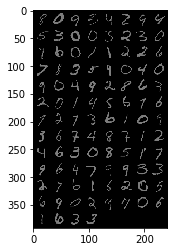

In [26]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

In [27]:
images.shape

torch.Size([100, 1, 28, 28])

As we are using linear layers not 2D convs at some stage we will need to flatten the data to batches of this shape

In [29]:
images.view(batch_size, -1).size()

torch.Size([100, 784])

### Linear model in Pytorch.

Note than in Keras (Sequential) in first layer we use Dense(number_hidden, input_shape)
    
In Pytorch the order is flipped Linear(input_shape, number_hidden)

In [47]:
class MLPNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(MLPNet, self).__init__()
        self.fc1= nn.Linear(image_h*image_w, 500)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        #we start with input of this shape
        #x.shape: torch.Size([100, 1, 28, 28])
        x = x.view(-1, image_h*image_w)
        #and flatten to this
        #x.shape: torch.Size([100, 784])
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.1, training=self.training)
        x = F.relu(self.fc2(x))
        y_pred = self.fc3(x)
        return y_pred

In [48]:
model = MLPNet()


In [49]:
if is_cuda:
    model = model.to(device)

In [50]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

We can use CrossEntropyLoss or break down into nll_loss of log_softmax see https://pytorch.org/docs/master/_modules/torch/nn/functional.html#cross_entropy

In [51]:
criterion = nn.CrossEntropyLoss()


### Train

In [52]:
def fit(epoch, model, data_loader, phase='train', volatile=False):
    if phase == 'train':
        model.train()
    if phase == 'val':
        #just sets evaluation mode - doesnt actually 'evaluate' anything
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(data_loader):
        if batch_idx==0:
            print(f'x.shape: {x.shape}, target.shape: {target.shape}')
        if is_cuda:
            x, target = x.to(device), target.to(device)
        x, target = Variable(x, volatile), Variable(target)
        if phase == 'training':
            #as backward() accumulates gradients, we  zero them at the start of a new minibatch. 
            optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, target)
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        running_loss += loss.item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'train':
            loss.backward()
            optimizer.step()
        if (batch_idx+1)%100 == 0 or (batch_idx+1)==len(data_loader):
            print(f'epoch: {epoch}, batch: {batch_idx}, av train loss: {ave_loss}, running loss: {running_loss}, loss: {loss.item()}')
            
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy
        

In [53]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(num_epochs):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

x.shape: torch.Size([100, 1, 28, 28]), target.shape: torch.Size([100])
epoch: 0, batch: 99, av train loss: 2.3037566286783253, running loss: 230.26728129386902, loss: 2.3059628009796143
epoch: 0, batch: 199, av train loss: 2.303309595380365, running loss: 460.5058259963989, loss: 2.3075780868530273
epoch: 0, batch: 299, av train loss: 2.302288824028746, running loss: 690.6635658740997, loss: 2.308011770248413
epoch: 0, batch: 399, av train loss: 2.2999595998300806, running loss: 920.7198882102966, loss: 2.2985119819641113
epoch: 0, batch: 499, av train loss: 2.29905725466137, running loss: 1150.8235182762146, loss: 2.295510768890381
epoch: 0, batch: 599, av train loss: 2.302289562851153, running loss: 1381.0180864334106, loss: 2.2988154888153076
training loss is 0.023 and training accuracy is 5972/60000       9.0
x.shape: torch.Size([100, 1, 28, 28]), target.shape: torch.Size([100])
epoch: 0, batch: 99, av train loss: 2.299040314837196, running loss: 230.14632606506348, loss: 2.2980763

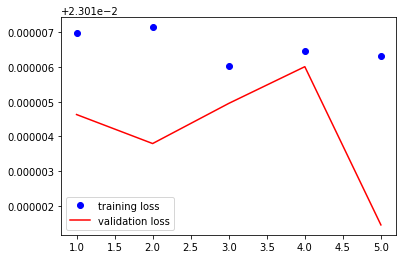

In [64]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

In [55]:
train_losses[0]

0.02301696810722351